In [82]:
!pip install numpy_financial
!pip install OpenFisca-Core
!pip install OpenFisca-France

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy_financial as npf
import sys
import asyncio
from time import time
from threading import Timer
import numpy as np 
import json
import requests
import ast
import requests
import urllib.parse
import json

def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled, timer = False, None
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args, new_kwargs = args, kwargs
            if not scheduled:
                scheduled = True
                new_wait = max(0, wait - time_since_last_call)
                timer = Timer(new_wait, call_it)
                timer.start()
        return throttled
    return decorator



from pprint import pprint  # data pretty printer

from openfisca_core.simulation_builder import SimulationBuilder
from openfisca_france import FranceTaxBenefitSystem

tax_benefit_system = FranceTaxBenefitSystem()

You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


Hypothèses:

- Pas d'apport en capitaux propres donc 100% financé 

Scénario

Input

In [621]:
#Profil investisseur
revenus_mensuel = 0 #input user
credit_en_cours = 0 #input user

#Profil bien
destination_bien = "LO" #list: ["Résidence Locative", "Résidence à usage mixte", "Professionnel", "Résidence principal", "Résidence secondaire ou en vue de retraite"] #creditlogement.fr
nature_operation = 'NEUF' #raw_data 
departement_bien = "76" #à ajouter
ville_bien = 'Rouen' #à ajouter
nombre_lots_programme = "OneTo10"#list: [OneTo10,ElevenTo24,TwentyFiveTo99,OneHundredTo249,TwoFiftyTo499,FiveHundredOrMore]  #à ajouter
surface_annexe = 0
surface_terrasse = 0
surface_habitable = 55
rentabilite_brut = 0.05
inflation = -0.03 #Point à vérifier 

#Financement
nature_pret = "PBC" #prêt_bancaire_classique #à ajouter
type_emprunt = "" #list available in immobilier.notaires.fr #à ajouter
taux_dettes_interets_assurance = 0.0019
periodicite = 12 #à ajouter
dettes_mensualite = revenus_mensuel*0.35 #output variable
type_garantie = "caution" #list: [Caution, Hypothèque, PPD]
echeance = 1

#Acquisition
apport_initial = 0 #input user
annee_operation = 2022 #annee_livraison 




#Indexation_annuelle
#! Point de vigilence à calculer en fonction de l'année de l'opération 
index_loyer = 0.01
index_charges = 0.02
index_valeur_bien = 0.02

#Hypothèse charges
taux_frais_gestion = 0.03 #%Loyers
taux_charges = 0.13
charges_tf = 500
taux_provision_travaux_actif = 0.002 #Provision 

#Fiscalité 
ass_ir = [0, 0.06, 0.04, 1, 1]
ass_csg = [0, 0.0165, 0.016, 0.09, 1]

taux_plus_value_ir_immobilier = 0.19
taux_plus_value_csg_immobilier = 0.1720

#Fiscalité LMNP/Censi-Bouvard

taux_tva_acquisition = 0.2 #list ?

#Amortissement

amortissement={"terrain": [{"taux_acquisition": 0.2}],
               "gros_oeuvre": [{"taux_acquisition": 0.35}, {"duree": 35}],
               "facade": [{"taux_acquisition": 0.15}, {"duree": 20}],
               "chauffage_electricite": [{"taux_acquisition": 0.15}, {"duree": 10}],
               "agencement": [{"taux_acquisition": 0.15}, {"duree": 10}],
               "mobilier": [{"duree": 10}],
              }



#Autres données
departement_outre_mer = ["971", "972", "973", "974", "976"]


Function to call

In [297]:
#formula to calculate debt
#choose when input are entered 
#dettes mensualité => variable 
import sys

def _financement(revenus_mensuel, dettes_interets_assurance, periodicite, duree_emprunt, dettes_periodicite):
    if revenus_mensuel < 2500:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0132
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0152
        elif int(duree_emprunt) == 15:
            dettes_interets = 0.0161
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0171
        elif int(duree_emprunt) == 25:
            dettes_interets = 0.0186
        else:
            print("Something is wrong")
            sys.exit(0)
    elif revenus_mensuel >= 2500 and revenus_mensuel < 4250:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0123
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0142
        elif int(duree_emprunt) == 15:
            dettes_interets = 0.0152
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0162
        elif int(duree_emprunt) == 25:
            dettes_interets = 0.0172
        else:
            print("Something is wrong")
            sys.exit(0)
    elif revenus_mensuel >= 4250 and revenus_mensuel < 6750:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0112
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0136
        elif int(duree_emprunt) == 15:
            dettes_interets = 0.0141
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0156
        elif int(duree_emprunt) == 25:
            dettes_interets = 0.0164
        else:
            print("Something is wrong")
            sys.exit(0)
    elif revenus_mensuel >= 6750:
        if int(duree_emprunt) == 5:
            dettes_interets = 0.0099
        elif int(duree_emprunt) == 10:
            dettes_interets = 0.0121
        elif int(duree_emprunt) == 15:
            dettes_interets == 0.0132
        elif int(duree_emprunt) == 20:
            dettes_interets = 0.0142
        elif int(duree_emprunt) == 25:
            dettes_interets == 0.0153
        else:
            print("Something is wrong")
            sys.exit(0)
            
    #https://python.plainenglish.io/how-to-use-python-for-financial-calculations-8fd5a692a506
    # Calculate the maximum amount to borrow given a specific payment 
    montant_emprunte = npf.pv((dettes_interets+dettes_interets_assurance)/periodicite,
                         int(duree_emprunt)*periodicite,
                         int(dettes_periodicite) * -1)

    return  (int(montant_emprunte), dettes_interets)

#financement = _financement(revenus_mensuel, dettes_interets_assurance, periodicite, duree_emprunt, dettes_periodicite)
#print(financement)

def _frais_notaires(categorie_bien, departement_bien, type_emprunt, nombre_lots_programme,  prix_acqusition,  valeur_mobilier_acquisition):

    """
    test_function does blah blah blah.
    
    :param categorie_bien (type):
    :param departement_bien (type): 
    :param type_emprunt (type): 
    :param nombre_lots_programme (list[OneTo10,ElevenTo24,TwentyFiveTo99,OneHundredTo249,TwoFiftyTo499,FiveHundredOrMore]): 
    :param prix_acqusition (type): 
    :param valeur_mobilier_acquisition (type):

    :return: describe what it returns
    """
    
    url = f'https://www.immobilier.notaires.fr/pub-services/inotr-www-calculs/v1/frais-acquisition?categorieBien={str(categorie_bien)}&codeInsee={str(departement_bien)}&empruntAvecHypotheque={str(type_emprunt)}&nombreLogement={str(nombre_lots_programme)}&prixAcquisition={int(prix_acqusition)}&valeurMobilier={int(valeur_mobilier_acquisition)}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36',
        'Referer': "https://www.immobilier.notaires.fr/fr/frais-de-notaire",
    }
    response = requests.get(url, headers=headers)
    json_response = json.loads(response.content.decode())
    total_frais_notaires = json_response["totalFrais"]
    return total_frais_notaires

#https://fr.luko.eu/conseils/guide/frais-garantie-pret-immobilier/

def _frais_garantie_bancaire(type_garantie, nature_pret, montant_acquisition, destination_bien, nature_operation):

    if type_garantie == "caution": 
        
        #format to expected format api
        data={"naturePret":nature_pret,"montant":str(montant_acquisition)}
        converted_data=urllib.parse.urlencode({'pret1': json.dumps(data)})

        #adapt to API required data
        if nature_operation == "NEUF":
            operation="AQN" #acquisition_neuf

        url = f'https://www.crelog.com/simulateurs/moteurTarification?isEmployePreteur=false&{converted_data}&pret2=%7B%22naturePret%22%3A%22%22%2C%22montant%22%3A%22%22%7D&pret3=%7B%22naturePret%22%3A%22%22%2C%22montant%22%3A%22%22%7D&pret4=%7B%22naturePret%22%3A%22%22%2C%22montant%22%3A%22%22%7D&destinationBien={destination_bien}&natureOperation={operation}'
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36',
            'Referer': "https://www.crelog.com/SimulatorGarantieInternet.shtml",
        }
        response = requests.get(url, headers=headers)
        json_response = json.loads(response.content.decode())
        dettes_initial_garantie=json_response["responseMoteurClassic"]["montantEmprunteurTotal"]
        dettes_restitution_fmg=json_response["responseMoteurClassic"]["montantQuotePartTotal"]
        return {"dettes_initial_garantie":dettes_initial_garantie, "dettes_restitution_fmg": dettes_restitution_fmg}

#frais_garantie_bancaire  = _frais_garantie_bancaire(type_garantie, nature_pret, montant_emprunte, destination_bien, nature_operation)
#print(frais_garantie_bancaire)



In [313]:
#################################################################################################################################################

"""
Calcul de fiscalité 
"""



def _utils_abattement_plus_value(actif_periode, taux_applicable):
    periode_detention = actif_periode + 1
    abattement = 0
    if periode_detention < 6:
        abattement = taux_applicable[0]

    if periode_detention >= 21 or periode_detention in range(6,22):
        abattement += (min(22, periode_detention) - 6) * taux_applicable[1]

    if periode_detention > 22:
        #print("periode_detention", periode_detention)
        abattement += taux_applicable[2] 

    if periode_detention >= 23 or periode_detention in range (23,30):
        if taux_applicable == 1:
            abattement = 1
        else:
            abattement += (min(31, periode_detention) - 23) * taux_applicable[3]
    if periode_detention > 30:
        abattement = taux_applicable[4]
    return abattement

#################################################################################################################################################

"""
Calcul pour pinel
"""


def _zone_fiscales(departement_bien, ville_bien):
        
    url = f'https://www.logisneuf.com/api/v1/geographie/departements/{str(departement_bien)}/villes'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
        'Referer': "https://www.logisneuf.com/calcul-loyer-pinel",
        'x-requested-with': 'XMLHttpRequest',
    }
    zone_fiscales = ""
    
    response = requests.get(url, headers=headers)
    json_response = json.loads(response.content.decode())
    for villes_object in json_response["villes"]:
        if villes_object["nom"] == ville_bien:            
            zone_fiscales = villes_object["zone_fiscales"]            
            break
    return zone_fiscales

def _zone_bien_eligible_pinel(surface_annexe, surface_terrasse, surface_habitable, zone_fiscales):
    
    url = f'https://www.logisneuf.com/api/v1/calculateurs/calcul/loyer-pinel?surfaceAnnexe={str(surface_annexe)}&surfaceTerrasse={str(surface_terrasse)}&surfaceHabitable={str(surface_habitable)}&zone={str(zone_fiscales)}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
        'Referer': "https://www.logisneuf.com/calcul-loyer-pinel",
        'x-requested-with': 'XMLHttpRequest',
    }
        
    response = requests.get(url, headers=headers)
    if response.status_code == 422:
        return 0
    if response.status_code == 200:
        return 1
    return 0

#print(_bien_eligible_pinel(surface_annexe, surface_terrasse, surface_habitable, _zone_fiscales(departement_bien, ville_bien)))

def _bien_max_loyer(surface_annexe, surface_terrasse, surface_habitable, zone_fiscales):
    
    url = f'https://www.logisneuf.com/api/v1/calculateurs/calcul/loyer-pinel?surfaceAnnexe={str(surface_annexe)}&surfaceTerrasse={str(surface_terrasse)}&surfaceHabitable={str(surface_habitable)}&zone={str(zone_fiscales)}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
        'Referer': "https://www.logisneuf.com/calcul-loyer-pinel",
        'x-requested-with': 'XMLHttpRequest',
    }
        
    response = requests.get(url, headers=headers)                
    json_response = json.loads(response.content.decode())
    return json_response["data"]["loyerPinel"]['loyerMaximum']
    

#print(_zone_fiscales(departement_bien, ville_bien))
#print(_bien_max_loyer(surface_annexe, surface_terrasse, surface_habitable, _zone_fiscales(departement_bien, ville_bien)))


def _bien_eligible_pinel(nature_operation, valeur_actif, surface_annexe, surface_terrasse, departement_bien, ville_bien):
    #non-couvert : son prix de location est inférieur au prix du marché (de 20 %) mais plafond mis en place
    if nature_operation != "NEUF":
        print("Non eligible Pinel parce que non neuf")
        return 0
    if _zone_bien_eligible_pinel(surface_annexe, surface_terrasse, surface_habitable, _zone_fiscales(departement_bien, ville_bien)) == 0:
        print("Non eligible Pinel parce que zone géographique non éligible")
        return 0
    if valeur_actif/surface_habitable > 5500:
        print("Attention le prix au mètre carré est supérieur au plafond requis")
    
    #https://www.lecomparateurassurance.com/defiscalisation/103375-guide/108375-qu-est-que-double-plafond-loi-pinel#:~:text=La%20loi%20Pinel%20met%20en,soit%20la%20zone%20du%20logement
    return 1


#################################################################################################################################################


"""
Calcul LMNP
"""

def _bien_eligible_lmnp():
    #non-couvert : Acheter un logement meublé ou le meubler + Être lié par un bail commercial à un gestionnaire de résidence + Ne pas être inscrit au registre du commerce et des sociétés (RCS) en tant que loueur de meublés professionnel (LMP).

    if nature_operation != "NEUF":        
        #! Point de vigilence
        print("Non eligible parce que LMNP non-neuf n'est pas couvert pour le moment")
        return 0
    return 1



606.63


Initialisation de la simulation

#Le but est de matcher les besoins d'un investisseurs avec sa capacité financière.

In [741]:
def _calcul_activite_investissement(montant_emprunte, type_garantie, frais_garantie_bancaire, repartition_acquisition, nature_operation, departement_bien, type_emprunt, nombre_lots_programme):
    """
    Fonction qui permet de calculer les frais d'acquisitions et les frais de travaux 
    3 batchs de variable : input_fixe / input_user 
    :param montant_emprunte (int): Partant de la capacité d'emprunt pour estimer l'investissement
    :param frais_notaires (int): Calcul de frais de notaires fait lors de 1er étape
    :param frais_garantie_bancaire (str): Calcul de frais de notaires fait lors de 1er étape et à convert en dict
    :param repartition_acquisition (dict): Un dictionnaire en fonction du régime.
    :param valeur_mobilier_acquisition (type):
    :param type_garantie (str): nature de la garantie uniquement la caution bancaire est traitée aujourd'hui (ajout d'hypothèque et de ppd à prévoir)

    :return (dict): Calcul du capex de l'investissement 
    """
    #Format données
    frais_garantie_bancaire_formatted = ast.literal_eval(frais_garantie_bancaire) #! Point de vigilence à voir jupyter widget pour dict

    
    #Output attendu
    capex = {}
    
        
    #Calcul des frais d'acquisition
    #! Point de vigilence : Calcul biaisé par la méthodologie demandée par Adomos
  


    #Output intermédiaire 
    valeur_actif = {} #représente la valeur de l'actif
    valeur_actif["detail"] = {}
    valeur_actif["detail"]["frais_garantie_bancaire_formatted"] = frais_garantie_bancaire_formatted
    valeur_actif["brut"] = montant_emprunte 
    valeur_actif["net"] = montant_emprunte - frais_notaire - frais_garantie_bancaire_formatted["dettes_initial_garantie"]  
    
    for key, value in repartition_acquisition.items():
        valeur_actif[str(key)] = value * valeur_actif["brut"]        
     

    #Calcul frais de notaire
    frais_notaires = _frais_notaires(nature_operation, departement_bien, type_emprunt, nombre_lots_programme,  montant_emprunte,  valeur_actif["mobilier"])
    valeur_actif["detail"]["frais_notaire"] = frais_notaires

    
    #Travaux
    #!Point de vigilence à traiter lorsque les biens anciens seront à traiter
    
    #Format output
    capex["frais_acquisition"] = valeur_actif
        
    return capex

#print(_calcul_activite_investissement(300000, 3000, type_garantie, "{'dettes_initial_garantie': 415.32, 'dettes_restitution_fmg': 178.0}", repartition_acquisition))


def _calcul_financement(apport_capital, nature_pret, montant_emprunte, echeance, duree_emprunt, periodicite, dettes_interets, taux_dettes_interets_assurance, duree_detention_bien=None):
    """
    Fonction qui permet de calculer les frais bancaires et l'apport 
    La fonction prend en compte calcul sur toute la durée de l'emprunt ainsi que de calculer à l'instant le statut de la dette à l'instant T (variable => duree_detention_bien)
    
    :param apport_capital (type):
    :param: nature_pret (str): PBC: prêt bancaire classqiue
    :param montant_emprunte (type): 
    :param echeance (Boolean): à échoir ou à échu 
    :param duree_emprunt (int): data saisie par l'user
    :param periodicite (int): mensualité data statique
    :param dettes_interets (float): taux choisit en fonction du taux actuel et la masse de revenus
    :param duree_detention_bien (int/optional): une durée qui capte la temporalité pour avoir le montant de la dette et des intérêts à l'instant t

    :return (dict): finacement_total, pour le moment uniquement le cas de la dette senior est traitée (voir d'autres type de crédit)
    """
    
    #Ouput
    total_financement = {}
    
    #Type de financement - Traitement du cas unique de 
    #! Point de vigilence pas de financement en capitaux propres possible et uniquement cas dettes seniors traitées
    dettes_senior = {}
    total_financement["capitaux_propres"] = {}


    #Optional Durée Detention 
    if duree_detention_bien is None:
        duree_detention_bien = duree_emprunt
    
    #Hypothèse - Financière 
    per = np.arange(duree_emprunt*periodicite) + echeance
    ipmt = npf.ipmt(dettes_interets/periodicite, per, duree_emprunt*periodicite, montant_emprunte) * -1
    ppmt = npf.ppmt(dettes_interets/periodicite, per, duree_emprunt*periodicite, montant_emprunte) * -1
    #pmt = npf.pmt(dettes_interets/periodicite, duree_emprunt*periodicite, montant_emprunte) * -1
    
    #Calcul Taux Intérêts
    dettes_interet_payees = []
    for i in range(0, periodicite*duree_emprunt):
        #print("i <= duree_detention_bien*periodicite", i <= duree_detention_bien*periodicite)
        if i % periodicite == 0 and i <= duree_detention_bien*periodicite:
            dettes_interet_payees.append(np.sum(ipmt[i:i+periodicite]))
            
    
    #Calcul Assurance sur prêt 
    dettes_assurance_payees = [taux_dettes_interets_assurance*montant_emprunte for i in range(duree_emprunt)]

            
    #Calcul du Principal de la dettes
    dettes_principal_payees = []

    for i in range(0, periodicite*duree_emprunt):
        if i % periodicite == 0 and i <= duree_detention_bien*periodicite:
            dettes_principal_payees.append(np.sum(ppmt[i:i+periodicite]))

    #Calcul du principal restant dû
    dettes_restant_a_payer = np.sum(ppmt[(duree_detention_bien + 1)*periodicite:])  
    
    #Output
    dettes_senior["dettes_interet_payees"] = dettes_interet_payees
    dettes_senior["dettes_assurance_payees"] = dettes_assurance_payees
    dettes_senior["dettes_principal_payees"] = dettes_principal_payees
    dettes_senior["dettes_restant_a_payer"] = dettes_restant_a_payer

    total_financement = dettes_senior
    
    return total_financement


#print(_calcul_financement(0, "PBC", 200000, 1, 25, 12, 0.01, taux_dettes_interets_assurance, duree_detention_bien=None))


def _calcul_operationnel(regime, valeur_actif, index_loyer, index_charges, taux_charges, charges_tf, taux_frais_gestion, nombre_periodes, max_duree_pinel=None):
    
    opex = {}
    #taux_frais_gestion = 0.03
    #taux_charges = 0.12
            
    
    #Loyer
    loyer_total = []

    loyer_libre_initiaux = [rentabilite_brut*valeur_actif] * (duree_emprunt)

    if regime == 'pinel':
    
        loyer_pinel_annuel = [int(_bien_max_loyer(surface_annexe, surface_terrasse, surface_habitable, _zone_fiscales(departement_bien, ville_bien)))*12 ]*int(max_duree_pinel)
        loyer_libre_ajuste = loyer_libre_initiaux[int(max_duree_pinel):]
        loyer_total = loyer_pinel_annuel + loyer_libre_ajuste
        
    if regime == 'lmnp':                
                        
        loyer_total = loyer_libre_initiaux
    
    opex["loyer"] = [loyer_total[i]*(1+index_loyer)**i for i in range(nombre_periodes)]
    
    #Calcul Charges opérationnelles
    
    #Frais de gestion   
    charges = []
    for i, loyer in enumerate(opex["loyer"]):
        charges_opex = loyer*taux_charges
        charges_tf = 500
        charges.append((charges_opex+charges_tf)*(1+index_charges)**i)

        #Charges tf non recup => !Point de vigilence données statiques qui impactent fortement le modèle  / Attention tf static   
    opex["charges_tf_non_recup"] = charges    
    opex["frais_gestion"] = [taux_frais_gestion*loyer_total[i]*(1+index_loyer)**i for i in range(nombre_periodes)]    
    
    #Calcul Charges non-opérationnelles

    #Calcul Amortissement
    total_depenses_amortissement=pd.DataFrame()

    if regime == 'lmnp':
        liste_dataframe = []

        #for taux_acquisition, duree in amortissement:
        for objet, valeurs in amortissement.items():
            if len(valeurs) == 2:
                duree_vie = valeurs[1]['duree']
                valeur_comptable_amortissement_debut = valeurs[0]['taux_acquisition'] * valeur_actif
                valeur_residuelle = 0
                temp_total_depenses_amortissement = []
                for i in range(1,duree_vie+1):
                    depenses_amortissement=((valeur_comptable_amortissement_debut-valeur_residuelle))/duree_vie     
                    valeur_comptable_amortissement_fin=((valeur_comptable_amortissement_debut-valeur_residuelle)*(duree_vie))/duree_vie
                #Save data 
                    temp_total_depenses_amortissement.append(depenses_amortissement)

                liste_dataframe.append(pd.DataFrame({str(objet): temp_total_depenses_amortissement}))


        total_depenses_amortissement = pd.concat(liste_dataframe, ignore_index=True, axis=1).fillna(0)
        total_depenses_amortissement["somme"] = total_depenses_amortissement.sum(axis=1).fillna(0)
    
    opex["amortissement"] = total_depenses_amortissement["somme"][:nombre_periodes] if regime == "lmnp" else [0] * int(nombre_periodes)
    opex["amortissement_restant"] = total_depenses_amortissement["somme"][nombre_periodes:].sum() if regime == "lmnp" else [0] * int(nombre_periodes)

        
    return opex

def _calcul_resultat(periodes_simulation, revenu, frais_gestion, charges_tf_non_recup, amortissement, interets_assurance, interets_deductibles):
    """
    Pour la simulation, on considère que la simulation début en fin de période de l'année 2022.
    3 points à voir : compte de résultat, flux de tréso, ajustement du flux de tresorerie si paiement anticipé
    """
    
    df = pd.DataFrame({'year':periodes_simulation,
                       'revenu':revenu,
                       'frais_gestion':frais_gestion,
                       'charges_tf_non_recup':charges_tf_non_recup,
                       'amortissement': amortissement,
                       'interets_assurance': interets_assurance,
                       'interets_deductibles': interets_deductibles,
                      })
    df = df.set_index("year")
    df['EBTDA'] = df['revenu']-df['frais_gestion']-df['charges_tf_non_recup']-df['interets_assurance']
    df['EBT'] = df['revenu']-df['frais_gestion']-df['charges_tf_non_recup']-df['interets_assurance']-df['amortissement']
    return df


def _calcul_fiscalite(annees_fiscales, annees_bien_detenu, valeur_actif, regime, EBTDA, amortissement, max_duree_pinel):#, impots_sans_investissement):
    """
    Normalement, il devrait avoir un ajustementt au niveau de la période pour la période fiscale
    
    
    """
    #Output    
    charges_fiscales = {}
    impots_sans_investissement = {}
    impots_avec_investissement = {}
    
    #Initialisation des données de l'investisseur sur openfisca
    #impots_sans_investissement = _utils_simulation_openfisca(_simulation_openfisca_investisseur(salaire_imposable, annees_fiscales, annees_bien_detenu, valeur_actif), declarants, annees_fiscales)    
    impots_sans_investissement = _simulation_openfisca_investisseur(salaire_imposable, declarants, annees_fiscales, annees_bien_detenu, valeur_actif)

    #Contraintes et plafond des revenus brut
    if regime == 'lmnp':
        for key, value in impots_sans_investissement['rbg'].items():
            #Vérifier que le plafond n'est pas dépassé    
            if (EBTDA.loc[key] > min(23000, value)).any():
                print("Le plafond autorisé est dépassé par le modèle financier, sur la simulation la recette annuelle dépasse le plafond")
                sys.exit(0)
        
    #Calcul du net foncier 
    charges_fiscales['revenu_imposable'] = EBTDA - amortissement
    
    #!Point de vigilence : Marc a mis un plafond de deficit foncier reportable a 10700€    
    revenu_foncier = {}
    deficit_foncier = {}
    
    for key, value in charges_fiscales['revenu_imposable'].items():
        if int(value) >= 0:
            revenu_foncier[key] = value
        else:
            deficit_foncier[key] = value * - 1

    charges_fiscales["revenu_foncier"] = revenu_foncier
    charges_fiscales["deficit_foncier"] = deficit_foncier
        
        
    #Calcul d'économie d'impôts / Variation d'impôts 
    #impots_sans_investissement = _utils_simulation_openfisca(_simulation_openfisca_investisseur(salaire_imposable, annees_fiscales, annees_bien_detenu, valeur_actif), declarants, annees_fiscales)    
    #impots_sans_investissement = _simulation_openfisca_investisseur(salaire_imposable, declarants, annees_fiscales, annees_bien_detenu, 0)
    
    if regime == "pinel":        
        impots_avec_investissement = _simulation_openfisca_investisseur(salaire_imposable, declarants, annees_fiscales, annees_bien_detenu, valeur_actif, revenu_foncier, deficit_foncier, regime, int(max_duree_pinel))

    elif regime == "lmnp":
        impots_avec_investissement = _simulation_openfisca_investisseur(salaire_imposable, declarants, annees_fiscales, annees_bien_detenu, valeur_actif, revenu_foncier, deficit_foncier, regime, int(max_duree_pinel))
        #impots_avec_investissement = _utils_simulation_openfisca(_simulation_openfisca_investisseur(salaire_imposable, annees_fiscales, annees_bien_detenu, valeur_actif, revenu_foncier, deficit_foncier, regime), declarants, annees_fiscales)
        
        
    charges_fiscales["impots_sans_investissement"] = impots_sans_investissement
    charges_fiscales["impots_avec_investissement"] = impots_avec_investissement
    
    return charges_fiscales

#print(_calcul_fiscalite("lmnp", df['EBTDA'], df['amortissement']))
#_calcul_tresorerie(raw_regime, duree_simulation, annee_operation, annee_fiscale_investisseur, index_loyer, index_charges, index_valeur_bien, surface_annexe, surface_terrasse, surface_habitable, departement_bien, ville_bien, taux_frais_gestion, charges_tf_non_recup, taux_provision_travaux_actif, valeur_actif, montant_emprunte, dettes_interets, duree_emprunt)



def _calcul_tresorerie(df, dettes_principal, impots_sans_investissement, impots_avec_investissement):

    
    #Calcul flux de trésorerie

    df_tresorerie = df.copy()

    
    df_s = pd.Series(impots_sans_investissement, name='impots_sans_investissement').reset_index().drop(columns="index")
    df_a = pd.Series(impots_avec_investissement, name='impots_avec_investissement').reset_index().drop(columns="index")
    df_c = pd.concat([df_s, df_a], axis=1)
    
    df_tresorerie = df_tresorerie.reset_index()
    df_tresorerie = pd.concat([df_tresorerie, df_c], axis=1)
    df_tresorerie = df_tresorerie.set_index("year")

    #df_tresorerie["impots_sans_investissement"] = pd.Series(impots_sans_investissement) 
    #df_tresorerie["impots_avec_investissement"] = pd.Series(impots_avec_investissement)  
        
    #à traiter maintenant. #!Point de vigilence : frottement négatif entre frais d'acquisition et frais de financement et travaux non pris en compte pour le moment 
    #print("dettes_principal", dettes_principal)
    df_tresorerie['charges'] = df_tresorerie['frais_gestion'] + df_tresorerie['charges_tf_non_recup'] + df_tresorerie['interets_assurance'] + df_tresorerie['interets_deductibles'] + dettes_principal
    #print("charges", df_tresorerie["charges"])
    df_tresorerie['impot_variation'] = df_tresorerie["impots_avec_investissement"] - df_tresorerie["impots_sans_investissement"]
    df_tresorerie = df_tresorerie.drop(columns=['frais_gestion', 'charges_tf_non_recup', 'interets_assurance', 'interets_deductibles'])
    df_tresorerie['tresorie'] = df_tresorerie['revenu'] - df_tresorerie['charges'] + df_tresorerie['impot_variation'] 

    return df_tresorerie

def _calcul_kpi(regime, max_duree_pinel, reduction_pinel, df_tresorerie, duree_simulation, annees_bien_detenu, valeur_actif_brut, valeur_actif_net, index_valeur_bien, apport_capital, nature_pret, montant_emprunte, echeance, duree_emprunt, periodicite, dettes_interets, dettes_mensualite, taux_dettes_interets_assurance, taux_provision_travaux_actif, frais_notaire, valeur_mobilier_acquisition, amortissement_restant):
    """
    L'objectif est de calculer le tri annuel et l'ensemble des kpis pour chaque régime.
    La fonction va calculer le flux tresorerie sur la période de l'emprunt et avoir une variable paramètrable qui pourra signifier la durée de simulation totale.
    Il y a également des ajustements à faire annuel en fonction de l'année de l'arbitrage
    
    :param regime (str): pinel ou lmnp
    :param df_tresorerie (DataFrame): table de la trésorerie !Point de vigilence prévoir la scalabilité du traitement des données si besoin
    :param duree_simulation: input par le user !Point de vigilence pour le moment cette variable est à changer dans le code
        
    :return df_bilan (DatFrame): données brutes pour chaque simulation
    
    """
    
    #Output
    df_bilan={}
    reste_net_actif_valeurs = []
    variation_tva_valeurs = []
    tri_valeurs = []
    
        
    cf_simulation = {}
    
    
    for index, annee_vente_bien in enumerate(annees_bien_detenu):
        
        
        #Output
        financement = {}
        
        #Calcul de plus value à la revente
        valeur_bien_vente_nth = valeur_actif_brut*(1+index_valeur_bien)**int(index)
        financement  = _calcul_financement(apport_capital, nature_pret, montant_emprunte, echeance, duree_emprunt, periodicite, dettes_interets, taux_dettes_interets_assurance, index)


        plus_value_theo = valeur_bien_vente_nth - valeur_actif_net 
        plus_value_ir_immobilier = max(0, plus_value_theo*(1-_utils_abattement_plus_value(index, ass_ir))*taux_plus_value_ir_immobilier)
        plus_value_csg_immobilier = max(0, plus_value_theo*(1-_utils_abattement_plus_value(index, ass_csg))*taux_plus_value_csg_immobilier)
        impots_plus_value = plus_value_ir_immobilier+plus_value_csg_immobilier
        reste_net_actif = valeur_bien_vente_nth - financement["dettes_restant_a_payer"] - impots_plus_value
        reste_net_actif_valeurs.append(reste_net_actif) 

                
        #Contraintes
        #impot_recup
        impot_annulation = 0
        if regime == "pinel" and index + 1 < max_duree_pinel: 
            if reduction_pinel[int(annee_vente_bien)] > 0: #pinel
                impot_annulation = reduction_pinel[int(annee_vente_bien)]
                
        
        #calcul variation_tva
        last_value_tva = 0
        if regime == "lmnp":
            if index == 0:
                variation_tva_valeurs.append(valeur_actif_brut * 0.2)
            else:
                variation_tva_valeurs.append((1-min(1,index/20)) * valeur_actif_brut * 0.2 * -1) #Remboursement de la TVA au pro-rata si vente avant 20 ans.
            last_value_tva = variation_tva_valeurs[-1]


        #calcul tri
        last_value_tresorie = df_tresorerie['tresorie'].iloc[-1]

        value_tresorie = df_tresorerie["tresorie"].iloc[:index].tolist()

        #Calcul du flux de tresorie pour calcul IRR et ajout des variables d'ajustement
        if len(value_tresorie) == 0:                
            value_tresorie = last_value_tresorie + reste_net_actif + last_value_tva - impot_annulation
            tri_valeurs.append(npf.mirr(value_tresorie,dettes_interets,taux_provision_travaux_actif))
    

        else:
            value_tresorie[-1] = last_value_tresorie + reste_net_actif + last_value_tva - impot_annulation
            tri_valeurs.append(npf.mirr(value_tresorie,dettes_interets,taux_provision_travaux_actif))
                            
        if (duree_simulation - 1) == index:
            cf_simulation["Capital récupéré"] = value_tresorie[-1]
            cf_simulation["Gain net au bilan"] = reste_net_actif + df_tresorerie["tresorie"].loc[annee_vente_bien] #!Point de vigilence EST-CE que je prends en compte l'impôts sur la plus value ?.
            cf_simulation["Prix de revient"] = valeur_actif_net
            cf_simulation["Capital constitué"] = valeur_bien_vente_nth - financement["dettes_restant_a_payer"]
            cf_simulation["Valeur bien"] = valeur_bien_vente_nth
  
    if regime == "lmnp":
        df_tresorerie["variation_tva"] = variation_tva_valeurs    

                   
    df_tresorerie["reste_net_actif"] = reste_net_actif_valeurs
    df_tresorerie["tri"] = tri_valeurs  
    
    
    #print(df_tresorerie.transpose())
    print(df_tresorerie["tri"].plot())


    duree_simulation = duree_simulation - 1
    
    #output
    
    
    if regime == "pinel":
        df_bilan = pd.DataFrame({'Prix du bien immobilier': valeur_actif_brut, 
                                 'Frais de notaire': frais_notaire, 
                                 'Montant du prêt': montant_emprunte, 
                                 'Mensualité': dettes_mensualite, 
                                 'Loyer Mensuel': df_tresorerie['revenu'].iloc[0] / 12, 
                                 "Économie d'impôts": df_tresorerie['impot_variation'].iloc[:duree_simulation].sum(),                    
                                 'Impôts payés': df_tresorerie["impots_avec_investissement"].iloc[:duree_simulation].sum(), 
                                 "Effort d'épargne mensuel": df_tresorerie["tresorie"].iloc[:duree_simulation].mean()/12 * -1, 
                                 "Prix de revient": cf_simulation["Prix de revient"], 
                                 "Gain net au bilan": cf_simulation["Gain net au bilan"],
                                 "Rendement de votre épargne": df_tresorerie['tri'].iloc[duree_simulation],                             
                                 "Rente annuelle": df_tresorerie['revenu'].iloc[duree_simulation],
                                 "Capital récupéré": cf_simulation["Capital récupéré"],
                                }, 
                                index=["{} - données simulé pour {} ans".format(str(regime + "_" + str(max_duree_pinel)), duree_simulation + 1)])

    else: 
        revenus_net = df_tresorerie["tresorie"].iloc[duree_simulation] 
        df_bilan = pd.DataFrame({'Prix du bien immobilier': valeur_actif_brut,
                                 'Mobilier': valeur_mobilier_acquisition,
                                 'Frais de notaire': frais_notaire, 
                                 'Montant du prêt': montant_emprunte, 
                                 'Mensualité': dettes_mensualite, 
                                 'Loyer Mensuel': df_tresorerie['revenu'].iloc[0] / 12, 
                                 "Économie d'impôts": df_tresorerie['impot_variation'].iloc[:duree_simulation].sum(),                    
                                 'Impôts payés': df_tresorerie["impots_avec_investissement"].iloc[:duree_simulation].sum(), 
                                 "Effort d'épargne mensuel": df_tresorerie["tresorie"].iloc[:duree_simulation].min()/12 * -1,
                                 "Rendement de votre épargne": df_tresorerie['tri'].iloc[duree_simulation],
                                 "Capital constitué": cf_simulation["Capital constitué"],
                                 "Gain net au bilan": cf_simulation["Gain net au bilan"],
                                 "Reste à amortir": amortissement_restant,
                                 "Montant des revenus nets": revenus_net,
                                 "Soit une moyenne mensuelle de": (revenus_net)/12,
                                 "Rendement locatif": revenus_net/cf_simulation["Valeur bien"], #Au démarage : brut à t0
                                 "Rente annuelle": df_tresorerie['revenu'].iloc[:duree_simulation].iloc[-1],                                 
                                 "Capital récupéré": cf_simulation["Capital récupéré"],
                                }, index=["{} - données simulé pour {} ans".format(regime, duree_simulation + 1)])
    
    print(df_bilan.transpose())
        
    return df_bilan


    



Variables concernant l'investisseur

In [742]:
#Variables Investisseur => input par le CGP

#variable en fonction des scénarios
 #max_annee_pinel et duree_detention_bien en fonction de l'année de vente de pinel

#All variables have to represented by the following format : {'Date1': value1, 'Date2': value2, ...}
#All None has to be calculated  
#All int or str has be provided by the use case and can be modified for example purposes
#All variable = {} has to be provided a conditional reason to fill the data based on what is calculated in previous func OR it could be input (for exemple Denormadie)
def _cas_investisseur(annee_fiscale_investisseur, situation, declarants, age, salaire_imposable, nb_enfant):
    profil = {}

    if declarants == 1:
        profil["declarants"] = ['parent1']
    if situation == "celibataire":
        profil["celibataire_ou_divorce"] = {annee_fiscale_investisseur : True}
        profil["maries_ou_pacses"] = {annee_fiscale_investisseur : False}

    if situation == "couple":
        profil["maries_ou_pacses"] = {annee_fiscale_investisseur : False}
        profil["celibataire_ou_divorce"] = {annee_fiscale_investisseur : True}

        
    profil["age"] = {annee_fiscale_investisseur: age}
    profil["salaire_imposable"] = salaire_imposable

    nb_part = 0
    for enfant in range(1, nb_enfant + 1):
        if enfant < 3:
            nb_part += 0.5
            profil["nb_pac"] = nb_part
        else:
            nb_part += 1
            profil["nb_pac"] = nb_part

    
            
    return profil

def _simulation_openfisca_investisseur(salaire_imposable, declarants, annees_fiscales, annees_bien_detenu, valeur_actif, revenu_foncier={}, deficit_foncier={}, regime=None, duree_regime=None): 
    #nb_prediction


    def _prediction_variable(var, inflation=0):
        (fist_year, first_value), *rest = var.items()
        for index, year in enumerate(annees_fiscales):
            var.update({str(year): int(first_value)*(1+inflation)**index})        
        return var
    
    def create_dict_openfisca(liste_annee_detection, value):
        projected_dict = {}
        for year in liste_annee_detection:
            projected_dict[str(year)] = value
            return projected_dict

    def _utils_simulation_openfisca(simulation, declarants, annees_fiscales):
        #Initialisation des données fiscales de l'investisseur 

        #! Je dois récupérer la données avant deficit foncier et pinel 

        impots={}
        rbg={}
        iaidrdi = {}
        csg={}
        reductions={}
        pinel={}
        total={}

        for i, year in enumerate(annees_fiscales):  
            if i > 0 or len(annees_fiscales) == 1: #Exclude first year but check if len > 1 for forecast
                if len(declarants) == 1: #!Point de vigilence si plusieurs déclération il faudra traiter

                    #Impôts sur le revenu
                    rbg_value = (simulation.calculate('rbg', str(year)))[0]
                    rbg[int(year)] = float(rbg_value)
                    iaidrdi_value = (simulation.calculate('iaidrdi', str(year)))[0]
                    iaidrdi[int(year)] = float(iaidrdi_value)


                    #Contribution sociale généralisée
                    csg_value = (simulation.calculate('csg', str(year)))[0]
                    #print("csg__",  csg_value)
                    csg[int(year)] = float(csg_value)

                    #Réduction des impôts
                    reductions_value = (simulation.calculate('reductions', str(year)))[0]  
                    reductions[int(year)] = float(reductions_value)

                    pinel_value = (simulation.calculate('rpinel', str(year)))[0]
                    pinel[int(year)] = float(pinel_value)

                    #locmeu=simulation.calculate('locmeu', str(year))[0]
                    total_value = (iaidrdi_value) + (csg_value)
                    total[int(year)] = float(total_value)



                else:
                    print("Déclarant > 1 cas non traitée pour le moment")

        #output
        impots["rbg"] = rbg
        impots["iaidrdi"] = iaidrdi
        impots["csg"] = csg
        impots["reductions"] = reductions
        impots["pinel"] = pinel
        impots["total"] = total


        return impots
        
    #Investisseur 
    #parent1_age = {YEAR: 30}
    #parent2_age = {YEAR: 18}
    #nb_adult = {YEAR: 2}
    #maries_ou_pacses = {YEAR: True}
    #nb_pac = {YEAR: 2}
    
    YEAR = str(annees_fiscales[0])
    

    #Calcul iaidrdi
    iaidrdi = None

    #Calcul ip_net
    ip_net = None
    #cncn_info_i
    #decote
    #ir_plaf_qf
    
    #Calcul simulations => toutes les 
    rpinel = None

    #Calcul ir_ss_qf
    rni = None #Revenu net imposable

    #Calcul rni
    rng = None #Revenu net global
    abat_spe = {YEAR: 0} #Abattements spéciaux pour personne agé / ou pour enfants à charge ayant fondé un foyer distinct

    #Calcul rng
    #! Détail charges_deduc si besoin
    rbg = None #Revenu brut global
    csg_patrimoine_deductible_ir = None #csg_patrimoine_deductible_ir
    charges_deduc = {YEAR: 0} #Charges déductibles

    #Calcul csg_patrimoine_deductible_ir
    #! Attention le rbg doit calculer avant de calculer cette variable
    f6de = {YEAR: 0} #CSG déductible calculée sur les revenus du patrimoine
    f2bh = {YEAR: 0} #Revenus des lignes 2DC, 2CH, 2TS, 2TR déjà soumis au prélèvement sociaux avec CSG déductible

    #Calcul rbg
    revenu_categoriel = None #Revenus Categoriels
    deficit_ante = None #Déficit global antérieur
    f6gh = {YEAR: 0} #Sommes à ajouter au revenu imposable
    #nbic_impm_i = {YEAR: 0} #Locations meublées imposables sans CGA (régime du bénéfice réel) #individus
    #nacc_pvce_i = {YEAR: 0} #Locations meublées non professionnelles: Revenus imposables sans CGA (régime du bénéfice réel) #individus

    #Calcul revenu_categoriel 
    #! Détail et abattement à détailler plus tard si besoin
    revenu_categoriel_tspr = {YEAR: salaire_imposable} #Revenu catégoriel - Traitements, salaires, pensions et rentes
    revenu_categoriel_capital = {YEAR: 0} #Revenu catégoriel - Capitaux
    revenu_categoriel_foncier = None #Revenu catégoriel - Foncier
    revenu_categoriel_non_salarial = {YEAR: 0} #Revenu catégoriel - Revenus personnels non salariés
    revenu_categoriel_plus_values = {YEAR: 0} #Revenu catégoriel - Plus-values

    #Calcul deficit_ante à considérer dépendant des années précendantes calculées
    f6fa = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -6
    f6fb = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -5
    f6fc = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -4
    f6fd = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -3
    f6fe = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -2
    f6fl = {YEAR: 0} #Deficits globaux des années antérieures non encore déduits les années précédentes: année de perception des revenus -1

    #Calcul revenu_categoriel_foncier
    f4ba = revenu_foncier #Revenus fonciers imposables
    f4bb = deficit_foncier #Déficit imputable sur les revenus fonciers
    f4bc = {YEAR: 0} #Déficit imputable sur le revenu global
    f4bd = {YEAR: 0} #Déficits antérieurs non encore imputés
    f4be = {YEAR: 0} #Micro foncier: recettes brutes sans abattement

    #Pinel
    f7nb = {} #Denormandie: Investissements réalisés en 2019 en métropole avec engagement de location de 9 ans
    f7nc = {} #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 6 ans
    f7nd = {} #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 9 ans
    f7qi = {}
    f7qj = {}
    f7qk = {}
    f7ql = {}
    f7qm = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 6 ans
    f7qn = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 9 ans
    f7qo = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 6 ans
    f7qp = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 9 ans
    f7qr = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 6 ans
    f7qs = {YEAR: 0} #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 9 ans
    f7qt = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 6 ans
    f7qu = {YEAR: 0} #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 9 ans
    
    #Calcul Projection pour Pinel
    #! Point de vigilence si Pinel déjà dans le portefeuille cette méthode sera à revoir et si arbritage entre 6 et 9    
    if regime == "pinel":
        if int(duree_regime) == 6 and departement_bien in departement_outre_mer:
            f7qy = create_dict_openfisca(annees_bien_detenu, valeur_actif)
        else:
            f7qy = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 6 ans

        if int(duree_regime) == 9 and departement_bien in departement_outre_mer:
            f7qq = create_dict_openfisca(annees_bien_detenu, valeur_actif)
        else:
            f7qq = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 9 an

        if int(duree_regime) == 6 and departement_bien not in departement_outre_mer:
            f7qw = create_dict_openfisca(annees_bien_detenu, valeur_actif)
        else:
            f7qw = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 6 ans

        if int(duree_regime) == 9 and departement_bien not in departement_outre_mer:
            f7qx = create_dict_openfisca(annees_bien_detenu, valeur_actif)
        else:
            f7qx = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 9 ans

    else:
        f7qy = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 6 ans
        f7qq = {YEAR: 0} #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 9 an
        f7qw = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 6 ans
        f7qx = {YEAR: 0} #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 9 ans
        
    #Calcul Projection pour LMP/Censi-Bouvard
    if regime == "lmnp":        
        f7pz = create_dict_openfisca(annees_bien_detenu, valeur_actif)
    else:
        f7pz = {YEAR: 0} 


    #Vente
    #f3vz = valeur_bien_vente

    TEST_CASE = {
        'individus': {
            'parent1': {
                'age': parent1_age,
            },
        },
        'foyers_fiscaux': {
            'foyer_fiscal1': {
                'declarants': declarants,
                #Situation familiale
                'celibataire_ou_divorce': _prediction_variable(celibataire_ou_divorce),
                'maries_ou_pacses': _prediction_variable(maries_ou_pacses),        
                "nb_adult": _prediction_variable(nb_adult),
                "nb_pac": _prediction_variable(nb_pac),
                #Revenu foyer_fiscaux
                "revenu_categoriel_tspr": _prediction_variable(revenu_categoriel_tspr, inflation),
                "revenu_categoriel_capital": _prediction_variable(revenu_categoriel_capital),
                #"revenu_categoriel_foncier": _prediction_variable(revenu_categoriel_foncier),
                #Revenu foncier
                "f4ba": (f4ba),
                "f4bb": (f4bb),
                "f4bc": _prediction_variable(f4bc),
                "f4bd": _prediction_variable(f4bd),
                "f4be": _prediction_variable(f4be),
                "revenu_categoriel_non_salarial": _prediction_variable(revenu_categoriel_non_salarial),
                "revenu_categoriel_plus_values": _prediction_variable(revenu_categoriel_plus_values),
                "f6gh": _prediction_variable(f6gh),
                #Deficit antérieur
                "f6fa": _prediction_variable(f6fa),
                "f6fb": _prediction_variable(f6fb),
                "f6fc": _prediction_variable(f6fc),
                "f6fd": _prediction_variable(f6fd),
                "f6fe": _prediction_variable(f6fe),
                "f6fl": _prediction_variable(f6fl),
                #Deduction et abbattements
                "charges_deduc": _prediction_variable(charges_deduc),
                "abat_spe": _prediction_variable(abat_spe),        
                #Pinel
                'f7nb': (f7nb), #Denormandie: Investissements réalisés en 2019 en métropole avec engagement de location de 9 ans
                'f7nc': (f7nc), #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 6 ans
                'f7nd': (f7nd), #Denormandie: Investissements réalisés en 2019 en outre-mer avec engagement de location de 9 ans
                'f7qi': f7qi,
                'f7qj': f7qj,
                'f7qk': f7qk,
                'f7ql': f7ql,
                'f7qm': _prediction_variable(f7qm), #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 6 ans
                'f7qn': _prediction_variable(f7qn), #Investissements locatifs intermédiaires en métropole réalisés en 2017 avec engagement de location 9 ans
                'f7qo': _prediction_variable(f7qo), #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 6 ans
                'f7qp': _prediction_variable(f7qp), #Investissements locatifs intermédiaires en outre-mer réalisés en 2017 avec engagement de location 9 ans
                'f7qr': _prediction_variable(f7qr), #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 6 ans
                'f7qs': _prediction_variable(f7qs), #Investissements locatifs intermédiaires en métropole réalisés en 2018 avec engagement de location 9 ans
                'f7qt': _prediction_variable(f7qt), #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 6 ans
                'f7qu': _prediction_variable(f7qu), #Investissements locatifs intermédiaires en outre-mer réalisés en 2018 avec engagement de location 9 ans
                'f7qw': _prediction_variable(f7qw), #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 6 ans
                'f7qx': _prediction_variable(f7qx), #Investissement locatifs intermédiaires en métropole réalisés en 2019 avec engagement de location 9 ans
                'f7qy': _prediction_variable(f7qy), #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 6 ans
                'f7qq': _prediction_variable(f7qq), #Investissement locatifs intermédiaires en outre-mer réalisés en 2019 avec engagement de location 9 an
                #LMNP/Censi-Bouvard
                "f7pz": _prediction_variable(f7pz),
                
            }
        }
    }

    #test if input data are correct
    simulation_builder = SimulationBuilder()
    simulation = simulation_builder.build_from_entities(tax_benefit_system, TEST_CASE)
    # activate the trace
    #simulation.trace = True
    
    impots = _utils_simulation_openfisca(simulation, declarants, annees_fiscales)
    
    return impots


In [743]:
def _programme_eligible(valeur_actif, surface_annexe, surface_terrasse, departement_bien, ville_bien):
    """
    Fonction pour vérifier l'éligibilité du bien en fonction du ou des programmes.
    !Point de vigilence, pas de traitement pour 
    """
    #Il faut intégrer la partie investisseur 
    programme_fiscale_a_traiter = ["pinel", "lmnp"]
    
    zone_fiscales = _zone_fiscales(departement_bien, ville_bien)
    liste_eligible = []
    #Test Pinel
    for programme in programme_fiscale_a_traiter:
        if "pinel" and _bien_eligible_pinel(nature_operation, valeur_actif, surface_annexe, surface_terrasse, departement_bien, ville_bien) == 1:
            liste_eligible.append(programme)
        if "lmnp" and _bien_eligible_lmnp():
            liste_eligible.append(programme)
            
    return liste_eligible

#print(_programme_eligible(nature_operation, valeur_actif, surface_annexe, surface_terrasse, departement_bien, ville_bien))

#montant_emprunte, frais_notaire, type_garantie, frais_garantie_bancaire, repartition_acquisition

def _simulation_optimisation(
    #Infos Bien
    surface_annexe, 
    surface_terrasse, 
    departement_bien, 
    ville_bien, 
    #Hypohèses Simulation
    annee_operation,    
    taux_dettes_interets_assurance,
    taux_provision_travaux_actif,
    echeance,
    nature_pret,
    periodicite,
    index_loyer,
    index_charges,
    index_valeur_bien,
    #User
    montant_emprunte,
    frais_notaire,
    frais_garantie_bancaire,
    dettes_interets,    
    duree_emprunt,
    apport_capital,
    dettes_mensuelles,
):
    
    """
    Fonction pour simuler tous les scénarios possibles pour des biens NEUFs et les produits fiscaux suivants : Pinel et LMNP
    
    """
    #Output
    output_tables = []
    output_capex = {}
    output_total_financement = {}
    output_opex = {}
    output_resultat = {} #dataframe
    output_charges_fiscales = {}
    output_tresorerie = {} #dataframe
    output_kpi = {} #dataframe
    
    
    #Différentes simulation
    repartition_acquisition = {}
    cas_a_etudier = []
    frais_acquisition = 0
    valeur_actif = 0
    valeur_mobilier = 0

    
    #Préparation de la période de simulation
    duree_fiscale = duree_emprunt + 1 #Voir point de vigilence
    annees_fiscales = list(range(int(annee_fiscale_investisseur), int(annee_fiscale_investisseur)+duree_fiscale))
    annees_bien_detenu = list(range(int(annee_operation), int(annee_operation)+duree_emprunt)) 
    periodes_simulation = [annee_operation+i for i in range(duree_emprunt)]
    duree_simulation = 25
    
    #Vérifier l'éligbilité des programmes
    valeur_actif_théorique = montant_emprunte - frais_notaire 
    eligible = _programme_eligible(valeur_actif_théorique, surface_annexe, surface_terrasse, departement_bien, ville_bien)

    
    #{'frais_acquisition': {'detail': {'frais_notaire': 3000, 'frais_garantie_bancaire_formatted': {'dettes_initial_garantie': 415.32, 'dettes_restitution_fmg': 178.0}}, 'total': 296584.68, 'terrain': 29658.468, 'immobilier': 252096.97799999997, 'mobilier': 14829.234}}
    
    #Spécifité en fonction des régimes
    if "pinel" in eligible:
        cas_a_etudier.append("pinel_6")
        cas_a_etudier.append("pinel_9")
        repartition_acquisition = dict({"terrain": 0.1, "immobilier": 0.85, "mobilier": 0})
    
    if "lmnp" in eligible:
        cas_a_etudier.append("lmnp")
        repartition_acquisition = dict({"terrain": 0.1, "immobilier": 0.90, "mobilier": 0.05})

    #print(cas_a_etudier)
    for cas in cas_a_etudier:
        #! Point de vigilence : inflation 
        if "_" in cas:
            parsed_regime = cas.split("_")
            regime = parsed_regime[0]
            max_duree_pinel = int(parsed_regime[1])
        else:
            regime = cas
            max_duree_pinel=0
            #print(regime)
            
        #Hypothèses pour la simulation concernant l'acquisition
        #output_capex = _calcul_activite_investissement(montant_emprunte, type_garantie, frais_garantie_bancaire, repartition_acquisition)
        output_capex = _calcul_activite_investissement(montant_emprunte, type_garantie, frais_garantie_bancaire, repartition_acquisition, nature_operation, departement_bien, type_emprunt, nombre_lots_programme)

        frais_acquisition_net = output_capex["frais_acquisition"]["net"]
        frais_acquisition_brut = output_capex["frais_acquisition"]["brut"]
        valeur_actif = output_capex["frais_acquisition"]["immobilier"]
        valeur_mobilier = output_capex["frais_acquisition"]["mobilier"]

        output_total_financement = _calcul_financement(apport_capital, nature_pret, montant_emprunte, echeance, duree_emprunt, periodicite, dettes_interets, taux_dettes_interets_assurance, duree_detention_bien=None)
        output_opex = _calcul_operationnel(regime, valeur_actif, index_loyer, index_charges, taux_charges, charges_tf, taux_frais_gestion, duree_simulation, max_duree_pinel)

        #Mise en place des dataframe
        output_resultat = _calcul_resultat(periodes_simulation=periodes_simulation,
                                           revenu=output_opex['loyer'], 
                                           frais_gestion=output_opex['frais_gestion'], 
                                           charges_tf_non_recup=output_opex['charges_tf_non_recup'], 
                                           amortissement=output_opex['amortissement'], 
                                           interets_assurance=output_total_financement['dettes_assurance_payees'], 
                                           interets_deductibles=output_total_financement['dettes_interet_payees'], 
                                           )
        
        output_charges_fiscales = _calcul_fiscalite(annees_fiscales, annees_bien_detenu, valeur_actif, regime, output_resultat["EBTDA"], output_resultat['amortissement'], max_duree_pinel)
                        
        output_tresorerie = _calcul_tresorerie(output_resultat, 
                                               output_total_financement["dettes_principal_payees"], 
                                               output_charges_fiscales["impots_sans_investissement"]["total"], 
                                               output_charges_fiscales["impots_avec_investissement"]["total"],
                                              )
        
        output_kpi = _calcul_kpi(regime,
                                 max_duree_pinel,
                                 output_charges_fiscales["impots_avec_investissement"]["pinel"],
                                 output_tresorerie, 
                                 duree_simulation, 
                                 annees_bien_detenu, 
                                 frais_acquisition_brut, 
                                 frais_acquisition_net,
                                 index_valeur_bien,
                                 apport_capital, 
                                 nature_pret, 
                                 montant_emprunte, 
                                 echeance, 
                                 duree_emprunt, 
                                 periodicite, 
                                 dettes_interets,
                                 dettes_mensualite,
                                 taux_dettes_interets_assurance,
                                 taux_provision_travaux_actif,
                                 frais_notaire,
                                 valeur_mobilier,
                                 output_opex["amortissement_restant"]
                                )                
    
        output_tables.append(output_kpi)        
        
        #print(output_tables)
    
    

    #loop and choose the project with the best IRR
    
    return output_tables

montant_emprunte = 69837
frais_notaire =  3955.2499999999995
dettes_interets = 0.0142
dettes_mensualite = 1000
frais_garantie_bancaire = "{'dettes_initial_garantie': 415.32, 'dettes_restitution_fmg': 178.0}"
duree_emprunt = 25 
apport_capital = 0



/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: divide by zero encountered in true_divide
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))
/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: invalid value encountered in multiply
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))


AxesSubplot(0.125,0.125;0.775x0.755)
                            pinel_6 - données simulé pour 25 ans
Prix du bien immobilier                             69837.000000
Frais de notaire                                     3955.250000
Montant du prêt                                     69837.000000
Mensualité                                           1000.000000
Loyer Mensuel                                         606.000000
Économie d'impôts                                  -10936.417969
Impôts payés                                       357692.582031
Effort d'épargne mensuel                               68.488144
Prix de revient                                     65466.430000
Gain net au bilan                                  105934.909123
Rendement de votre épargne                              0.066408
Rente annuelle                                       3990.350639
Capital récupéré                                   105934.909123


/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: divide by zero encountered in true_divide
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))
/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: invalid value encountered in multiply
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))


AxesSubplot(0.125,0.125;0.775x0.755)
                            pinel_9 - données simulé pour 25 ans
Prix du bien immobilier                             69837.000000
Frais de notaire                                     3955.250000
Montant du prêt                                     69837.000000
Mensualité                                           1000.000000
Loyer Mensuel                                         606.000000
Économie d'impôts                                   -7470.127930
Impôts payés                                       361158.872070
Effort d'épargne mensuel                               18.606315
Prix de revient                                     65466.430000
Gain net au bilan                                  105934.909123
Rendement de votre épargne                              0.079014
Rente annuelle                                       3990.350639
Capital récupéré                                   105934.909123


/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: divide by zero encountered in true_divide
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))
/usr/local/lib/python3.8/site-packages/openfisca_france/model/prelevements_obligatoires/prelevements_sociaux/cotisations_sociales/travail_non_salarie.py:166: RuntimeWarning: invalid value encountered in multiply
  - (0.007 * (assiette_pss > 5) * ((assiette_pss - 5) / assiette_pss))


AxesSubplot(0.125,0.125;0.775x0.755)
                               lmnp - données simulé pour 25 ans
Prix du bien immobilier                             69837.000000
Mobilier                                             3491.850000
Frais de notaire                                     3955.250000
Montant du prêt                                     69837.000000
Mensualité                                           1000.000000
Loyer Mensuel                                         261.888750
Économie d'impôts                                  -15144.060547
Impôts payés                                       353484.939453
Effort d'épargne mensuel                              173.423798
Rendement de votre épargne                              0.046221
Capital constitué                                  112328.432192
Gain net au bilan                                  106292.776799
Reste à amortir                                      6285.330000
Montant des revenus nets                            -

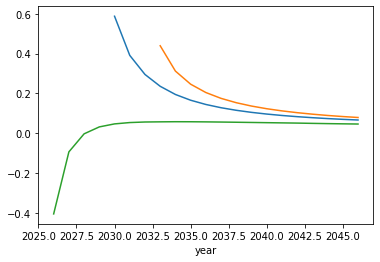

In [744]:
table = _simulation_optimisation(    #Caractèristiques bien 
    surface_annexe, 
    surface_terrasse, 
    departement_bien, 
    ville_bien, 
    #Simulation
    annee_operation,    
    taux_dettes_interets_assurance,
    taux_provision_travaux_actif,
    echeance,
    nature_pret,
    periodicite,
    index_loyer,
    index_charges,
    index_valeur_bien,
    #User
    montant_emprunte,
    frais_notaire,
    frais_garantie_bancaire,
    dettes_interets,    
    duree_emprunt,
    apport_capital,
    dettes_mensualite
)

In [745]:
#table[1].transpose()
result = table[0].append(table[1]).append(table[2])
result.transpose()

,pinel_6 - données simulé pour 25 ans,pinel_9 - données simulé pour 25 ans,lmnp - données simulé pour 25 ans
Prix du bien immobilier,69837.000000,69837.000000,69837.000000
Frais de notaire,3955.250000,3955.250000,3955.250000
Montant du prêt,69837.000000,69837.000000,69837.000000
Mensualité,1000.000000,1000.000000,1000.000000
Loyer Mensuel,606.000000,606.000000,261.888750
Économie d'impôts,-10936.417969,-7470.127930,-15144.060547
Impôts payés,357692.582031,361158.872070,353484.939453
Effort d'épargne mensuel,68.488144,18.606315,173.423798
Prix de revient,65466.430000,65466.430000,NaN
Gain net au bilan,105934.909123,105934.909123,106292.776799


Process

In [ ]:
from IPython.display import display
from ipywidgets import Button, Layout, Output, IntText, HBox, Label, Box, VBox, interact, Text


Page Wizard

Page 2

Définition des fonctions permettant de calculer le flux de trésorerie sur la période de la durée d'emprunt 

Cette partie utilise:
- les variables fixes 
- les fonctions d'utilités (_utils)  
- les données saisies par l'user

Cette partie sera utilisé pour la simulation du flux de trésorerie et traite uniquement le cas où l'investisseur ne connait pas sa capacité d'emprunt.


In [714]:
style = {'description_width': 'initial', 'width': '100%'}


def page_if_y():
    composant_capacite_emprunt = IntText(
        description="Capacité d'emprunt :",
        min=1000,
        disabled=False,
        style=style,
        continuous_update=True
    )
    
    composant_apport = IntText(
        min=0,
        description="Apport :",
        disabled=True,
        style=style
    )
    
    composant_frais_notaire = IntText()
    composant_frais_garantie_bancaire = Text()
    
    #Capacité d'achat 
    ui = VBox([composant_capacite_emprunt])

    def f_capacite_emprunt(capacite_emprunt, apport):
        output_capacite_emprunt = capacite_emprunt
        
        frais_notaires = _frais_notaires(nature_operation, departement_bien, type_emprunt, nombre_lots_programme,  output_capacite_emprunt,  0)
        frais_garantie_bancaire = _frais_garantie_bancaire(type_garantie, nature_pret, output_capacite_emprunt, destination_bien, nature_operation)
        output_capacite_achat = apport + output_capacite_emprunt - frais_notaires - frais_garantie_bancaire["dettes_initial_garantie"]
        print("frais_garantie_bancaire", frais_garantie_bancaire)

        print("Capacité d'achat : ", output_capacite_achat)
        print("dont")
        print("  Capacité d'emprunt : ", output_capacite_emprunt)
        print("  Frais de notaires et Frais de garantie : ", frais_notaires+frais_garantie_bancaire["dettes_initial_garantie"])

        #Frais notaire update
        def update_frais_notaires(*args):
            composant_frais_notaire.value = frais_notaires
        composant_capacite_emprunt.observe(update_frais_notaires, 'value')

        #Frais garantie bancaire update
        def update_frais_garantie_bancaire(*args):
            composant_frais_garantie_bancaire.value = str(frais_garantie_bancaire)

        composant_capacite_emprunt.observe(update_frais_garantie_bancaire, 'value')

        return (output_capacite_achat)

    capacite_achat = widgets.interactive_output(f_capacite_emprunt, {
        'capacite_emprunt': composant_capacite_emprunt,
        'apport': composant_apport,
    })

    display(ui, capacite_achat) 
    
    button = widgets.Button(description="Suivant")
    output = widgets.Output()

    #Show button
    
    @throttle(1000000000)
    def update_button(*args):
        display(button, output)

    composant_capacite_emprunt.observe(update_button, 'value')
    

    def on_button_clicked(b):
        with output:
            #insert here simulation function and process 
            #insert loading function 
            print(composant_frais_garantie_bancaire.value)
            print(composant_frais_notaire.value)
            print("Button clicked.")

    button.on_click(on_button_clicked)
    
def page_if_n(revenus_mensuel):

    #Styling
    box_layout = Layout(display='flex',
                        flex_flow='row',
                        align_items='stretch',
                        width='100%')

    #Composant
    composant_revenus = IntText(
        min=0,
        value=revenus_mensuel,
        description="Revenus par mois :",
        disabled=False,
        style=style,
        continuous_update=True
    )

    composant_credit = IntText(
        min=0,
        description="Crédit :",
        disabled=True,
        style=style
    )

    composant_apport = IntText(
        min=0,
        description="Apport :",
        disabled=True,
        style=style
    )
    
    composant_mensualite_emprunt = widgets.IntSlider(
        step=1,
        value=revenus_mensuel*0.35,
        max=revenus_mensuel*0.35,
        description='Mensualité (avec assurance) :',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style=style,
        layout=box_layout
    )

    composant_dettes_interets = IntText()
    composant_frais_notaire = IntText()
    composant_capacite_emprunt = IntText()

    composant_frais_garantie_bancaire = Text()

    #UI
    items_auto = [composant_revenus]
    box_auto = Box(children=items_auto, layout=box_layout)

    #Durée de l'emprunt
    composant_duree_emprunt = widgets.ToggleButtons(
        options=['5', '10', '15', '20', '25'],
        value='20',
        description="Durée de l'emprunt :",
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=['échéance 5 ans', 'échéance 10 ans', 'échéance 15 ans', 'échéance 20 ans', 'échéance 25 ans'],
        style=style,
        layout=box_layout
        #icons=['check'] * 3
    )


    #Mensualité de l'emprunt
    def update_mensualite_range(*args):
        #composant_mensualite_emprunt.value = 0.35 * composant_revenus.value 
        composant_mensualite_emprunt.max = 0.35 * composant_revenus.value

    composant_revenus.observe(update_mensualite_range, 'value') 
    #print("composant_mensualite_emprunt.value", composant_mensualite_emprunt.value)


    l = widgets.dlink((composant_revenus, 'value'), (composant_mensualite_emprunt, 'value'))

    if composant_revenus.value == "":
        l.unlink()

    #Capacité d'achat 
    ui = VBox([VBox([box_auto]), composant_duree_emprunt, composant_mensualite_emprunt])

    def f_capacite_emprunt(revenus_mensuel, composant_credit, composant_apport, duree_emprunt, dettes_mensualite):
        output_capacite_emprunt, dettes_interets = _financement(revenus_mensuel, taux_dettes_interets_assurance, periodicite, duree_emprunt, dettes_mensualite)        

        frais_notaires = _frais_notaires(nature_operation, departement_bien, type_emprunt, nombre_lots_programme,  output_capacite_emprunt,  0)
        frais_garantie_bancaire = _frais_garantie_bancaire(type_garantie, nature_pret, output_capacite_emprunt, destination_bien, nature_operation)
        output_capacite_achat = composant_apport + output_capacite_emprunt - frais_notaires - frais_garantie_bancaire["dettes_initial_garantie"]

        print("Capacité d'achat : ", output_capacite_achat)
        print("dont")
        print("  Capacité d'emprunt : ", output_capacite_emprunt)
        print("  Frais de notaires et Frais de garantie : ", frais_notaires+frais_garantie_bancaire["dettes_initial_garantie"])

        #Montant emprunté
        def update_capacite_emprunt(*args):
            composant_capacite_emprunt.value = output_capacite_emprunt

        if dettes_mensualite:            
            composant_mensualite_emprunt.observe(update_capacite_emprunt, 'value')

            
        #Frais financier intérêts
        def update_frais_financiers(*args):
            composant_dettes_interets.value = dettes_interets

        if dettes_mensualite:            
            composant_mensualite_emprunt.observe(update_frais_financiers, 'value')


        #Frais notaire update
        def update_frais_notaires(*args):
            composant_frais_notaire.value = frais_notaires

        if dettes_mensualite:
            composant_mensualite_emprunt.observe(update_frais_notaires, 'value')

       #Frais garantie bancaire update
        def update_frais_garantie_bancaire(*args):
            composant_frais_garantie_bancaire.value = str(frais_garantie_bancaire)

        if dettes_mensualite:
            composant_mensualite_emprunt.observe(update_frais_garantie_bancaire, 'value')

        return (output_capacite_achat)
     

    capacite_achat = widgets.interactive_output(f_capacite_emprunt, {
        'revenus_mensuel': composant_revenus,
        'composant_credit': composant_credit,
        'composant_apport': composant_apport,
        'duree_emprunt': composant_duree_emprunt,
        'dettes_mensualite': composant_mensualite_emprunt,
    })

    display(ui, capacite_achat)


    button = widgets.Button(description="Suivant")
    output_button = widgets.Output()

    #Show button
        

    def on_button_clicked(b):
        with output_button:
            #go 
            table = _simulation_optimisation(    
            #Caractèristiques bien 
            surface_annexe, 
            surface_terrasse, 
            departement_bien, 
            ville_bien, 
            #Simulation
            annee_operation,    
            taux_dettes_interets_assurance,
            taux_provision_travaux_actif,
            echeance,
            nature_pret,
            periodicite,
            index_loyer,
            index_charges,
            index_valeur_bien,
            #User
            montant_emprunte,
            composant_frais_notaire.value,
            frais_garantie_bancaire,
            composant_dettes_interets.value,    
            duree_emprunt,
            composant_apport.value,
            composant_mensualite_emprunt.value
            )
            
        result = table[0].append(table[1]).append(table[2])
        print(result.transpose())


    button.on_click(on_button_clicked)
    
    display(button, output_button)



In [715]:
def process_page():

    #Initialisation des cas à tester
    annee_fiscale_investisseur = 2021
    declarants = ['parent1']

    #Page 1
    buttonA = Button(description="Célibataire 30 ans, 30k€ imposable", layout=Layout(width='30%', height='40px'))
    buttonB = Button(description="Couple 35 ans, 60k€ imposable, 2 enfants", layout=Layout(width='30%', height='40px'))
    buttonC = Button(description="Célibataire 45 ans, 100k€ imposable", layout=Layout(width='30%', height='40px'))
    buttonD = Button(description="Célibataire 50 ans, 120k€ imposable, 3 enfants", layout=Layout(width='30%', height='40px'))
    outputA = Output()
    outputB = Output()
    outputC = Output()
    outputD = Output()

    #Page 2
    buttonY = Button(description="Je connais ma capacité d'emprunt", layout=Layout(width='30%', height='40px'))
    buttonN = Button(description="Aidez-moi à trouver ma capacité d'emprunt", layout=Layout(width='30%', height='40px'))
    outputY = Output()
    outputN = Output()

    #Function to call
    def hide_buttons():
        buttonY.close()
        buttonN.close()
    
    #Process    
    def on_buttonABCD_clicked(b):
        with outputA:            

            revenu_imposable = 30000
            cas = _cas_investisseur(annee_fiscale_investisseur, "celibataire", declarants,  revenu_imposable, 30, 2)               
            impots_sans_investissement = _simulation_openfisca_investisseur(revenu_imposable, declarants, [annee_fiscale_investisseur], [annee_fiscale_investisseur], 0)
            revenu_net_mensuel = (revenu_imposable - impots_sans_investissement["iaidrdi"][annee_fiscale_investisseur])/12
     
        with outputB:
            revenu_imposable = 60000
            cas = _cas_investisseur(2021, "couple", declarants,  60000, 35, 2)  
            impots_sans_investissement = _simulation_openfisca_investisseur(60000, declarants, [annee_fiscale_investisseur], [annee_fiscale_investisseur], 0)
            revenu_net_mensuel = (revenu_imposable - impots_sans_investissement["iaidrdi"][annee_fiscale_investisseur])/12

        
        with outputC:
            revenu_imposable = 100000
            cas = _cas_investisseur(2021, "celibataire", declarants, 100000, 45, 0)
            impots_sans_investissement = _simulation_openfisca_investisseur(100000, declarants, [annee_fiscale_investisseur], [annee_fiscale_investisseur], 0)
            revenu_net_mensuel = (revenu_imposable - impots_sans_investissement["iaidrdi"][annee_fiscale_investisseur])/12

            
        with outputD:
            revenu_imposable = 120000
            cas = _cas_investisseur(2021, "couple", declarants, 120000, 50, 3)
            impots_sans_investissement = _simulation_openfisca_investisseur(120000, declarants, [annee_fiscale_investisseur], [annee_fiscale_investisseur], 0)
            revenu_net_mensuel = (revenu_imposable - impots_sans_investissement["iaidrdi"][annee_fiscale_investisseur])/12             

            

        #Hide buttons
        buttonA.close()
        buttonB.close()
        buttonC.close()
        buttonD.close()  

        composant_cas = widgets.Text(value=str(cas), continuous_update=True)
        composant_revenus = widgets.IntText(value=revenu_net_mensuel, continuous_update=True)            

        def on_buttonY_clicked(b):
            with outputY:
                print("Je connais ma capacité d'emprunt")
                hide_buttons()
                page_if_y()

        def on_buttonN_clicked(b):
            with outputN:
                print("Je ne connais pas ma capacité d'emprunt")
                hide_buttons()


                page_if_n(revenu_net_mensuel)

                button = widgets.Button(description="Simulation")

                output = widgets.Output()

                #Show button for simulation

                @throttle(1000000000)
                def update_button(*args):
                    display(button, output)

                composant_revenus.observe(update_button, 'value')


                def on_button_clicked(b):
                    with output:
                        #clear all
                        #send interest data and emprunt and frais de notaires and frais de garantie and dettes_mensualite

                        #new page
                        print("Button clicked.")


                button.on_click(on_button_clicked)


        #Trigger step 2
        buttonY.on_click(on_buttonY_clicked)
        buttonN.on_click(on_buttonN_clicked)
        display(buttonN, outputN)




    buttonA.on_click(on_buttonABCD_clicked)
    buttonB.on_click(on_buttonABCD_clicked)
    buttonC.on_click(on_buttonABCD_clicked)
    buttonD.on_click(on_buttonABCD_clicked)
    
    display(buttonA, outputA)
    display(buttonB, outputB)
    display(buttonC, outputC)
    display(buttonD, outputD)
    
    #print("composant_revenus", composant_revenus.value)

    
        
    return 
    

In [746]:
process_page()

Button(description='Célibataire 30 ans, 30k€ imposable', layout=Layout(height='40px', width='30%'), style=Butt…

Output()

Button(description='Couple 35 ans, 60k€ imposable, 2 enfants', layout=Layout(height='40px', width='30%'), styl…

Output()

Button(description='Célibataire 45 ans, 100k€ imposable', layout=Layout(height='40px', width='30%'), style=But…

Output()

Button(description='Célibataire 50 ans, 120k€ imposable, 3 enfants', layout=Layout(height='40px', width='30%')…

Output()

In [718]:
result.transpose()

,pinel_6 - données simulé pour 25 ans,pinel_9 - données simulé pour 25 ans,lmnp - données simulé pour 25 ans
Prix du bien immobilier,69837.000000,69837.000000,69837.000000
Frais de notaire,3955.250000,3955.250000,3955.250000
Montant du prêt,69837.000000,69837.000000,69837.000000
Mensualité,1000.000000,1000.000000,1000.000000
Loyer Mensuel,606.000000,606.000000,261.888750
Économie d'impôts,-7890.503418,-3793.739746,-13993.807617
Impôts payés,360738.496582,364835.260254,354635.192383
Effort d'épargne mensuel,18.016879,-40.942699,156.044927
Prix de revient,-5169.178459,11811.179959,NaN
Gain net au bilan,106554.395103,106554.395103,106912.263267
